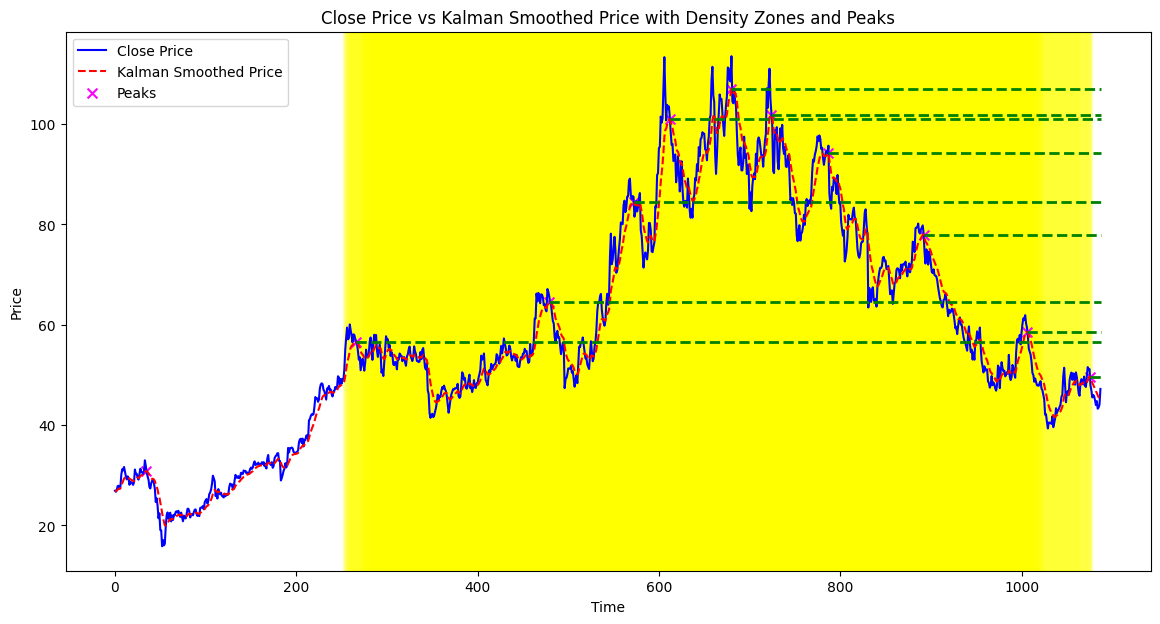

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from pykalman import KalmanFilter
from scipy.signal import find_peaks
from scipy.stats import gaussian_kde

# Define the directory for input data files
INPUT_DIRECTORY = 'Data/PriceData'

def calculate_atr(df, period=14):
    """ Calculate the Average True Range (ATR) for the given period. """
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    atr = true_range.rolling(window=period).mean()
    return atr



def load_random_file(directory):
    """ Utility function to load a random CSV file from a directory. """
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.csv')]
    return pd.read_csv(random.choice(files))

def apply_kalman_filter(df, column_name):
    """ Apply Kalman filter to smooth the data in the specified column. """
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=df[column_name].values[0],
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.03)
    
    state_means, _ = kf.filter(df[column_name].values)
    df['Kalman_Smooth'] = state_means.flatten()
    return df

def estimate_density(df, column_name):
    """ Estimate the density of the price data. """
    density = gaussian_kde(df[column_name])
    xs = np.linspace(df[column_name].min(), df[column_name].max(), 1000)
    density_values = density(xs)
    return xs, density_values, density




def find_density_zones(df, column_name, threshold_ratio=0.9):
    """Identify zones where the price density is above a certain threshold."""
    density = gaussian_kde(df[column_name])
    xs = np.linspace(df[column_name].min(), df[column_name].max(), 1000)
    density_values = density(xs)
    threshold = threshold_ratio * np.max(density_values)
    zones = []
    for i, x in enumerate(xs):
        if density_values[i] > threshold:
            # Find indices where price is within this high-density zone
            zone_indices = df.index[df[column_name].between(x - np.diff(xs)[0], x + np.diff(xs)[0])]
            if not zone_indices.empty:
                zones.append((zone_indices.min(), zone_indices.max()))
    return zones






def find_and_draw_peaks(df, column_name, ax, proximity_factor=0.5, prominence_factor=1.5):
    atr = calculate_atr(df)
    # Calculate prominence dynamically as a fraction of the ATR
    dynamic_prominence = atr.mean() * prominence_factor

    peaks, properties = find_peaks(df[column_name], prominence=dynamic_prominence)
    peak_values = df[column_name].iloc[peaks]

    consecutive_peaks = 1
    last_peak_value = None
    last_peak_index = None

    for i in range(1, len(peaks)):
        proximity_threshold = proximity_factor * atr.iloc[peaks[i]]
        if abs(peak_values.iloc[i] - peak_values.iloc[i-1]) <= proximity_threshold:
            if last_peak_index is None:
                last_peak_index = peaks[i-1]  # Start new group from the first peak
                last_peak_value = df[column_name].iloc[last_peak_index]
            consecutive_peaks += 1
        else:
            if last_peak_index is not None:
                ax.hlines(last_peak_value, last_peak_index, len(df), colors='green', linestyles='--', linewidth=2*consecutive_peaks)
                consecutive_peaks = 1  # Reset
            last_peak_index = peaks[i]  # Start new group
            last_peak_value = df[column_name].iloc[last_peak_index]

    # Draw the final ray, if applicable
    if last_peak_index is not None:
        ax.hlines(last_peak_value, last_peak_index, len(df), colors='green', linestyles='--', linewidth=2*consecutive_peaks)

    return peaks  # Return the peaks array for further use





def plot_prices_with_kalman_peaks_and_density_zones(df, zones):
    """ Plot the original and Kalman smoothed prices with identified density zones and peaks with horizontal rays. """
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(df.index, df['Close'], label='Close Price', color='blue')
    ax.plot(df.index, df['Kalman_Smooth'], label='Kalman Smoothed Price', color='red', linestyle='--')

    # Draw density zones
    for start, end in zones:
        ax.axvspan(start, end, color='yellow', alpha=0.1)

    # Detect and draw peaks
    peaks = find_and_draw_peaks(df, 'Kalman_Smooth', ax)
    
    # Scatter plot for peaks
    ax.scatter(df.index[peaks], df['Kalman_Smooth'][peaks], color='magenta', s=50, marker='x', label='Peaks')

    ax.set_title("Close Price vs Kalman Smoothed Price with Density Zones and Peaks")
    ax.set_xlabel("Time")
    ax.set_ylabel("Price")
    ax.legend()
    plt.show()



def process_and_plot_data(window_size=90):
    """ Load data, apply filters, and plot results with zones. """
    df = load_random_file(INPUT_DIRECTORY)
    df = df.tail(2000).reset_index(drop=True)
    df = apply_kalman_filter(df, 'Close')
    zones = find_density_zones(df, 'Kalman_Smooth')
    plot_prices_with_kalman_peaks_and_density_zones(df, zones)

if __name__ == '__main__':
    process_and_plot_data()



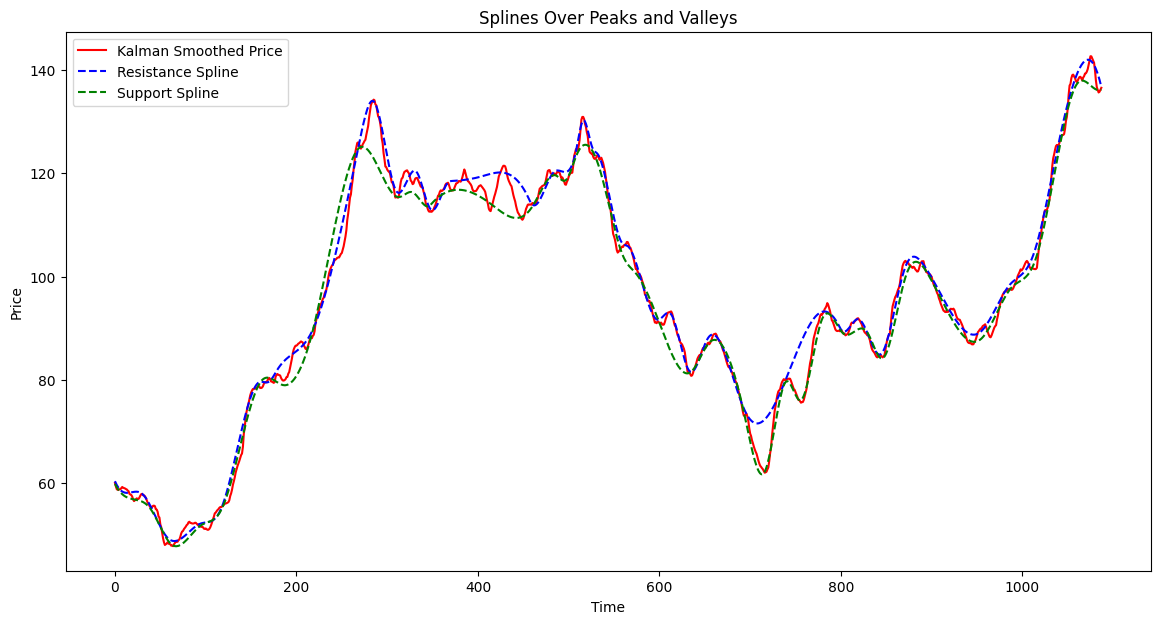

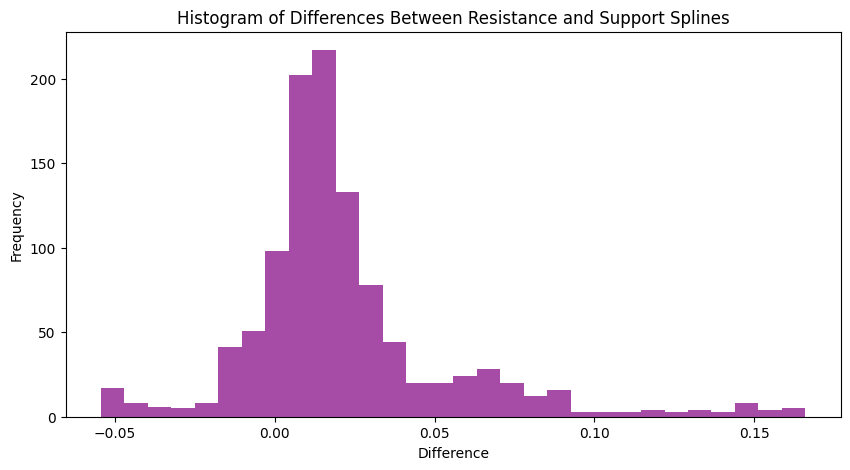

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from pykalman import KalmanFilter
from scipy.signal import find_peaks
from scipy.interpolate import UnivariateSpline

# Define the directory for input data files
INPUT_DIRECTORY = 'Data/PriceData'

def load_random_file(directory):
    """ Utility function to load a random CSV file from a directory. """
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.csv')]
    return pd.read_csv(random.choice(files))

def apply_kalman_filter(df, column_name):
    """ Apply Kalman filter to smooth the data in the specified column. """
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=df[column_name].values[0],
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.03)
    
    state_means, _ = kf.filter(df[column_name].values)
    df['Kalman_Smooth'] = state_means.flatten()
    return df

def plot_splines_over_peaks_and_valleys(df, column_name):
    """ Plot splines fitted to peaks and valleys, and create a histogram of the differences. """
    peaks, _ = find_peaks(df[column_name])
    valleys, _ = find_peaks(-df[column_name])
    
    # Adding artificial peaks and valleys at the ends of the data
    peaks = np.append(peaks, len(df) - 1)
    peaks = np.insert(peaks, 0, 0)
    valleys = np.append(valleys, len(df) - 1)
    valleys = np.insert(valleys, 0, 0)

    # Fitting splines to peaks and valleys
    spline_peaks = UnivariateSpline(peaks, df[column_name].iloc[peaks], s=len(peaks))
    spline_valleys = UnivariateSpline(valleys, df[column_name].iloc[valleys], s=len(valleys))

    # Calculate the differences between the two splines
    ##calculate the diffrence in terms of a percentage not the actual value
    difference = (spline_peaks(df.index) - spline_valleys(df.index))/spline_valleys(df.index)



    # Plotting the original data and splines
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(df.index, df[column_name], label='Kalman Smoothed Price', color='red')
    ax.plot(df.index, spline_peaks(df.index), label='Resistance Spline', color='blue', linestyle='--')
    ax.plot(df.index, spline_valleys(df.index), label='Support Spline', color='green', linestyle='--')
    ax.set_title("Splines Over Peaks and Valleys")
    ax.set_xlabel("Time")
    ax.set_ylabel("Price")
    plt.legend()
    plt.show()

    # Plotting the histogram of differences
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(difference, bins=30, color='purple', alpha=0.7)
    ax.set_title("Histogram of Differences Between Resistance and Support Splines")
    ax.set_xlabel("Difference")
    ax.set_ylabel("Frequency")
    plt.show()

def process_and_plot_data():
    """ Load data, apply filters, and plot results with splines over peaks and valleys. """
    df = load_random_file(INPUT_DIRECTORY)
    df = df.tail(2000).reset_index(drop=True)
    df = apply_kalman_filter(df, 'Close')
    plot_splines_over_peaks_and_valleys(df, 'Kalman_Smooth')

if __name__ == '__main__':
    process_and_plot_data()
